# Part 0:
## import everything
Run the cell below

In [1]:
# -*- coding: utf-8 -*-
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
import matplotlib.cm as cm
import warnings
import types
warnings.filterwarnings("ignore")
import sys, time
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.backends.backend_pdf
from sklearn.decomposition import KernelPCA
import mpl_toolkits.axes_grid1.inset_locator as inset
from matplotlib.ticker import FormatStrFormatter
import imageio



if "__file__" not in dir():
    %matplotlib inline
    %config InlineBackend.close_figures = False
    if OS()=='Linux':
        root="/data"
    elif OS()=='Windows':
        root="C:\\DATA\\"
    else:
        root="/Users/davidrobbe/Documents/Data/"
            
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommonNoteBookesPath)
    %run UtilityTools.ipynb
    %run Animal_Tags.ipynb
    %run loadRat_documentation.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run RunBatchRat_3_CompareGroups.ipynb
    %run BatchRatBehavior.ipynb
    currentNbPath=os.path.join(os.path.split(ThisNoteBookPath)[0],'BehavioralPaper','CtrlTrd.ipynb')
    %run $currentNbPath
    os.chdir(CWD)

    logging.getLogger().setLevel(logging.ERROR)
    
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
    }  

    print('os:',OS(),'\nroot:',root,'\nImport successful!')

os: Linux 
root: /data 
Import successful!


---
---


# part 1:

# DEFINITIONS

### If you don't know what to do, move to part 2

**group ET learning curve**

In [ ]:
def plot_learning_curve(ax, root, animalList, profile, TaskParamToPlot, 
                        stop_dayPlot):
    Results,_=get_rat_group_statistic(root,
                                      animalList,
                                      profile,
                                      parameter=param,
                                      redo=False,
                                      stop_dayPlot=stop_dayPlot,
                                      TaskParamToPlot=[TaskParamToPlot])
    
    goalTime=data_fetch(root, animal=animalList[0], profile=profile,
                        PerfParam= [lambda data:data.goalTime[-1]],
                        NbSession=0).values()
    goalTime=list(goalTime)[-1]
    
    x=np.arange(stop_dayPlot)+1
    data=np.array( list( Results[TaskParamToPlot].values() ) )
    y=np.nanpercentile(data,50,axis=0)
    yerr=np.nanpercentile(data,(25,75),axis=0)
#     np.random.seed(seed=seed)
    sigma=.3
    
    ax.errorbar(x,y,yerr=abs(yerr-y), ecolor='k', fmt='k-o',elinewidth=1, markersize=4, markerfacecolor='w',zorder=3)
    
#     for pts,day in zip(data.T,x):
#         jitter=np.random.uniform(low=day-sigma, high=day+sigma, size=len(pts))
#         ax.scatter(jitter,pts,s=2,c=colors, marker='o',zorder=1)

    
    if TaskParamToPlot=="percentile entrance time":
        ax.hlines(y=goalTime, xmin=x[0], xmax=x[-1], linestyle='--', lw=1, color='m', zorder=1)
        ax.text(x=x[0], y=goalTime[-1], s='Goal time', verticalalignment='center',
                color='m',backgroundcolor='w',fontsize=8, zorder=2)
        ax.text(x=x[0], y=1, s=f'$n={len(animalList)}$ rats', fontsize=8, zorder=5)
        ax.set_ylim([0,8])
        ax.set_yticks([0,3.5,7])
        ax.set_yticklabels([0,'',7])


    
    ax.set_xlim([x[0]-1,x[-1]+1])
    xtick=[1]
    for i in range(1,stop_dayPlot+1):
        if i%5==0:
            xtick.append(i)
    ax.set_xticks(xtick)
    ax.spines['bottom'].set_bounds(x[0],x[-1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    ax.set_xlabel('Session#')
    ax.set_ylabel(TaskParamToPlot)
    
    return ax

In [ ]:
if "__file__" not in dir():

    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control']
             }
    animalList=batch_get_animal_list(root,profile)
    animalList=['Rat103','Rat104','Rat110','Rat113','Rat120','Rat137','Rat138','Rat139','Rat140','Rat149',
                'Rat150','Rat151','Rat152','Rat161','Rat162','Rat163','Rat164','Rat165','Rat166','Rat215',
                'Rat216','Rat217','Rat218','Rat219','Rat220','Rat221','Rat222','Rat223','Rat224','Rat225',
                'Rat226','Rat227','Rat228','Rat229','Rat230','Rat231','Rat232','Rat246','Rat247','Rat248',
                'Rat249','Rat250','Rat251','Rat252','Rat253','Rat254','Rat255','Rat256','Rat257','Rat258',
                'Rat259','Rat260','Rat261','Rat262','Rat263','Rat264','Rat265','Rat297','Rat298','Rat299',
                'Rat300','Rat305','Rat306','Rat307','Rat308']

    TaskParamToPlot="percentile entrance time"
    stop_dayPlot =30
    
    plt.close('all')
    fig=plt.figure(figsize=(5,3))
    ax=fig.add_subplot(111);
    
    plot_learning_curve(ax, root, animalList, profile, TaskParamToPlot, stop_dayPlot)
    ax.set_ylabel('$ET$ (s)')

---

**plotting several consecutive trials**

In [ ]:
def plot_consecutive_trajectories(root, session, trials, ax):
    delta=1 #last delta second of position is not recorded
    data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);
    data.position_correction()
    try:
        detect_trial_end(data, trials)
    except:
        pass
    fps=data.cameraSamplingRate
    y1=param['treadmillRange'][0]
    y2=param['treadmillRange'][1]

    maxT=0
    for trial in trials:
        time=data.rawTime[trial]+maxT
        maxT=time[-1]+delta
        #plotting position
        ax.plot(time,data.position[trial],'k');
        #plotting entrance time
        ET=data.entranceTime[trial]+data.cameraToTreadmillDelay+time[0]
        if data.entranceTime[trial]!=data.maxTrialDuration[trial]:
            ax.plot(ET,data.position[trial][time[time<ET].argmax()+1],'rx')
        #plotting the goal time
        GT=data.goalTime[trial]+data.cameraToTreadmillDelay+time[0]
        ax.plot(GT,data.position[trial][time[time<GT].argmax()], marker='o',markeredgecolor='r', markerfacecolor='None')
        #plotting the highlight for trials
        x=(time[0], time[0]+data.timeEndTrial[trial]+data.cameraToTreadmillDelay)
        c='lime' if trial in data.goodTrials else 'tomato' if data.entranceTime[trial]<data.goalTime[trial] else 'cyan'
        ax.fill_betweenx(y=(y1,y2),x1=x[0],x2=x[1], color=c, alpha=.2)
    
    ax.set_xlim([-1,time[-1]+1])
    ax.set_ylim([y1-2,y2+2])
    ax.set_yticks([y1,y2/2,y2])
    ax.set_yticklabels([y1,'',y2])
#     ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position (cm)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    return ax
    
    
def add_legend_for_consecutive_trajectories(ax):
    o_marker = matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                       markeredgecolor='r', marker='o',
                                       markerfacecolor='None', markersize=6, label='Goal time')

    x_marker = matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                       markeredgecolor='r', marker='x',
                                       markerfacecolor='None', markersize=6, label='$ET$')


    g_patch = matplotlib.patches.Patch(edgecolor='k', facecolor='lime', label='Correct trial', alpha=1)
    r_patch = matplotlib.patches.Patch(edgecolor='k', facecolor='tomato', label='Incorrect trial', alpha=1)
    w_patch = matplotlib.patches.Patch(edgecolor='k', facecolor='white', label='Intertrial', alpha=1)



    leg=ax.legend(handles=[g_patch,r_patch,w_patch,o_marker,x_marker],loc=1, ncol=2, fontsize=8, framealpha=.6)
    return leg

In [ ]:
if "__file__" not in dir():
    session='Rat262_2018_07_12_15_47'
    trials=range(60,69)

    plt.close('all')
    ax=plt.figure(figsize=(20,3)).add_subplot(111);

    plot_consecutive_trajectories(root, session, trials, ax)
#     add_treadmill_to_axis(ax,path,Xextention=12)

In [ ]:
if "__file__" not in dir():
    fig=plt.figure(figsize=(9,4),dpi=100)
    naiveAx=fig.add_subplot(211)
    trainedAx=fig.add_subplot(212)
    
    #plotting naive
    session='Rat262_2018_06_04_15_38'
    trials=range(48,57)
    plot_consecutive_trajectories(root, session, trials, naiveAx)
    naiveAx.text(x=0, y=0, s=f'{session[:6]} naive')
    #plotting trained
    session='Rat262_2018_07_12_15_47'
    trials=range(60,69)
    plot_consecutive_trajectories(root, session, trials, trainedAx)
    trainedAx.text(x=0, y=0, s=f'{session[:6]} trained')
    

    
#     fig.savefig('/home/david/Pictures/tst.pdf',format='pdf')
    plt.show()
    plt.close('all')

---

**plotting the trajectories of above example sessions**

In [ ]:
def plot_trajectories(data,ax):
    posDict=data.position
    time=data.timeTreadmill #align on camera
    Colors=[]
    for trial in posDict:
        color="lime"
        if trial not in data.goodTrials:
            color="tomato"
        Colors.append(color)
        ax.plot(time[trial][:data.stopFrame[trial]], posDict[trial][:data.stopFrame[trial]],
               color=color, lw=.5, )
        

    ax.set_ylabel("X Position (cm)")
    ax.set_xlabel("Time (s) relative to camera start")
    
    ax.vlines(x=np.nanmedian(data.goalTime), 
              ymin=param['treadmillRange'][0], ymax=param['treadmillRange'][1], 
              colors='k',linestyle='--')
    
    return np.array(Colors)



def plot_trajectories_and_distributions(root, ax, session):
    data=Data(root,session[:6],session,redoPreprocess=False)
    y1,y2=treadmillRange=param['treadmillRange']
    
    color=plot_trajectories(data,ax=ax)
    
    position=get_positions_array_beginning(data,onlyGood=False,raw=False)
    position=position.T
    
    histT0,bins0=np.histogram(position[0,color=='lime'],30,range=(y1,y2), density=False)
    histT1,bins1=np.histogram(position[0,color=='tomato'],30,range=(y1,y2), density=False)
    
    maxBin=max([histT0.max(),histT1.max()])/3
    ax.barh(bins0[:-1],-histT0/maxBin,height=np.diff(bins0)[0],align='edge',left=-1.02*data.cameraToTreadmillDelay, color='lime', alpha=.6)
    ax.barh(bins1[:-1],-histT1/maxBin,height=np.diff(bins1)[0],align='edge',left=-1.02*data.cameraToTreadmillDelay, color='tomato', alpha=.6)

    
    ax.set_xlim([-4.2,data.maxTrialDuration[0]])
    ax.set_xticks((0,np.nanmedian(data.goalTime),np.nanmedian(data.maxTrialDuration)))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_ylim([y1,y2+2])
    ax.set_yticks([y1,y2/2,y2])
    ax.set_yticklabels([y1,'',y2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(ax.get_xticks()[0],ax.get_xticks()[-1])
    ax.spines['left'].set_position(('data',-data.cameraToTreadmillDelay))

    ax.set_xlabel('Trial time (s)')
    ax.set_ylabel('Position (cm)')

    return ax

In [ ]:
if "__file__" not in dir():
    #the inputs
    
    fig=plt.figure(figsize=(3,6),dpi=100)
    naiveAx=fig.add_subplot(211)
    trainedAx=fig.add_subplot(212)
    #plotting naive
    session='Rat262_2018_06_04_15_38'
    plot_trajectories_and_distributions(root, naiveAx, session)
    
    #plotting trained
    session='Rat262_2018_07_12_15_47'
    plot_trajectories_and_distributions(root, trainedAx, session)
    
    
#     fig.savefig('/home/david/Pictures/tst.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    plt.close('all')

---

**plot the probablity of initial position for correct trials**

In [ ]:
def initial_pos(root, profile, animalList, SessionRange, trdBins, ax):
    def et_and_initial_pos(data):
        et     =data.entranceTime
        initPos=np.array([data.position[i][data.startFrame[i]] for i in data.position])
        gt     =np.nanmedian(data.goalTime)

        if len(et)==len(initPos):
            return et,initPos,gt
        else:
            return None,None,None
    
    PerfParam=[et_and_initial_pos]
    initialPosB=[]
    initialPosG=[]
    countN=0
    for animal in  animalList:
        sessions=batch_get_session_list(root,[animal],profile=profile)['Sessions']
        data=data_fetch(root, animal=animal, profile=profile,
                        PerfParam= PerfParam,
                        NbSession=100)[PerfParam[0].__name__]
        data=data[SessionRange[0]:SessionRange[1]]

        for et,pos,gt in data:
            if et is None:
                countN+=1
                continue
            initialPosG.extend(list(pos[et>=gt]))
            initialPosB.extend(list(pos[et<gt]))
        
    logging.warning(f'{countN} sessions were removed, entranceTime != position')
    
    return np.array(initialPosG),np.array(initialPosB)
    
def plot_probablity_initial_pos(root,profile,animalList, SessionRange, trdBins, ax, pCum=True,):
        
    initialPosG,initialPosB= initial_pos(root, profile, animalList, SessionRange, trdBins, ax)

    Y1,Y2=param['treadmillRange']
    n,_,_=ax.hist(initialPosG,trdBins,density=True,edgecolor='None',color='lime'  ,alpha=.6, rwidth=1)
    m,_,_=ax.hist(initialPosB,trdBins,density=True,edgecolor='None',color='tomato',alpha=.6, rwidth=1)
    y0,y1=ax.get_ylim()
    
    
    ax2=ax.twinx()
    X=np.array(trdBins[1:])-trdBins.step/2
    Y=np.cumsum(n)*trdBins.step
    ax2.plot(X,Y,linewidth=1,color='lime', linestyle='--')
    Ybad=np.cumsum(m)*trdBins.step
    ax2.plot(X,Ybad,linewidth=1,color='tomato', linestyle='--')

    
    x=X[Y>=.8][0]
    y=Y[Y>=.8][0]
    ax2.hlines(y=y,xmin=x,xmax=trdBins[-1],alpha=.25,linewidth=.5,color='k',zorder=5)
    ax2.vlines(x=x,ymin=0,ymax=y          ,alpha=.25,linewidth=.5,color='k',zorder=5)
    ax.fill_betweenx(y=(y0,y1),x1=Y1,x2=x, facecolor=[.5,.5,.5,.2],edgecolor='None')
    
    xbad=X[Ybad>=.8][0]
    ybad=Ybad[Ybad>=.8][0]
    ax2.vlines(x=xbad,ymin=0,ymax=ybad,alpha=.25,linewidth=.5,color='k',zorder=5)

    
    ax2.spines['top'].set_visible(False)
    ax2.set_ylim([-.02,1.02])
#     ax2.spines['right'].set_color('m')
#     ax2.tick_params(axis='y', colors='m')
    ax2.set_ylabel('Cumu. Prob.',color='k')
    ax2.set_yticks([0,.8,1])
    ax2.set_yticklabels(['0','.8','1'])
    ax2.spines['bottom'].set_bounds(Y1,Y2)
    ax2.spines['right'].set_bounds(0,1)

    ax.set_xlabel('Init. position (cm)')
    ax.set_ylabel('Probability')
    ax.set_ylim((y0-y1)/100,y1)
    ax.set_xlim([trdBins[0]-trdBins.step,trdBins[-1]+trdBins.step])
    ax.set_xticks([Y1,x,xbad,Y2])
    ax.set_xticklabels([Y1,'%2.0f'%(x),'%2.0f'%(xbad),Y2])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(Y1,Y2)
    ax.spines['left'].set_bounds(0,y1)
    
    return ax2

In [ ]:
if "__file__" not in dir():
    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':['10'],
             'Tag':'Control'
                  }
    animalList=batch_get_animal_list(root,profile)
    animalList=animalList

    Y1,Y2=param['treadmillRange']
    SessionRange=[20,30]
    trdBins=range(Y1,Y2+1,1)
    
    plt.close('all')
    fig=plt.figure(figsize=(2,2),dpi=300)
    ax=fig.add_subplot(111)
    
    plot_probablity_initial_pos(root,profile,animalList, SessionRange, trdBins, ax)
    
    plt.show()


---
**Plot probablity of max position**

In [ ]:
def get_positions_array_Bad_StereotypedTrials(data,onlyBad=True):
    posDict=data.position
    #number of frames to keep 
    cs=data.cameraSamplingRate
    size=np.max(data.maxTrialDuration)*cs#int(abs(minTime*cs))
    #put all positions in a 2D array
    allTraj=[]
    for trial in posDict:
        if onlyBad and (trial in data.goodTrials):
            continue
        if data.entranceTime[trial] == data.maxTrialDuration[trial]:
            continue
        #index where the steretyped trajectory ends
        endIndex0=data.indexEndTrial[trial]
        endIndex1=(data.entranceTime[trial]+data.cameraToTreadmillDelay)*cs
        startIndex=data.startFrame[trial]
        if isNone(endIndex0):
            if isNone(endIndex1):
                continue
            elif endIndex1<startIndex:
                continue
            endIndex=int(endIndex1)
        elif isNone(endIndex1):
            endIndex=endIndex0
        else:
            endIndex=min([endIndex0,int(endIndex1)])
        
        pos=posDict[trial][startIndex:endIndex]
       
        allTraj.append(pos)

    allTraj=np.asarray(allTraj)
    return allTraj

def max_pos_trials(data, initialPos=15):
    data.position_correction()
    allTraj=get_positions_array_end_StereotypedTrials(data,onlyGood=True)
    badTraj=get_positions_array_Bad_StereotypedTrials(data,onlyBad=True)
    maxPos=[]
    badPos=[]
    try:
        for traj in allTraj:
            if traj[~np.isnan(traj)][0] < initialPos:
                maxPos.append(np.nanmax(traj))


        for traj in badTraj:
            if traj[~np.isnan(traj)][0] < initialPos:
                badPos.append(np.nanmax(traj))
    except IndexError:
        # due to lack of any non-nan point
        logging.error(f'error in trial position processing of {data.sessionPath}')
        
    return np.array(maxPos),np.array(badPos)

def prob_max_pos_for_correct(animalList, profile, SessionRange, trdBins):

    param=[max_pos_trials]

    rd=[]
    for animal in animalList:
        data=data_fetch(root,animal,profile, param, NbSession=SessionRange[1]+1)
        rd.append(data[param[0].__name__][SessionRange[0]:SessionRange[-1]])
    
    GData=dict.fromkeys(animalList,None)
    BData=dict.fromkeys(animalList,None)
    for i,animal in enumerate(animalList):
        GData[animal]=[]
        BData[animal]=[]
        for j in range(len(rd[i])):
            GData[animal].extend(rd[i][j][0])
            BData[animal].extend(rd[i][j][1])

    
    distanceB=[]
    distanceG=[]
    for col,animal in enumerate(animalList):
        distanceG.extend(GData[animal])
        distanceB.extend(BData[animal])
        
    distanceG=np.array(distanceG)
    distanceB=np.array(distanceB)
    PtotalG,_= np.histogram(a=distanceG,bins=trdBins,density=True)
    PtotalB,_= np.histogram(a=distanceB,bins=trdBins,density=True)
    
    return PtotalG, PtotalB


def plot_prob_max_pos(ax, animalList, profile, SessionRange, trdBins):
    
    PtotalG, PtotalB=prob_max_pos_for_correct(animalList,
                                             profile,
                                             SessionRange,
                                             trdBins)
    
    binSize=trdBins[1]-trdBins[0]    

    Gbar=ax.bar(x=trdBins[:-1], height=PtotalG,
                width=binSize, align='edge',
                edgecolor='None',color='lime',   alpha=.6, zorder=0, label='Correct trials')
    Bbar=ax.bar(x=trdBins[:-1], height=PtotalB,
                width=binSize, align='edge',
                edgecolor='None',color='tomato', alpha=.6, zorder=0, label='Error trials')

    y0,y1=ax.get_ylim()
    ax.set_xlabel('Max position (cm)')
    ax.set_ylabel('Probability')
    ax.set_ylim((y0-y1)/100,y1)
    ax.set_xlim([trdBins[0]-trdBins.step,trdBins[-1]+trdBins.step])
    ax.set_xticks([Y1,Y2/2,Y2])
    ax.set_xticklabels([Y1,'',Y2])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(Y1,Y2)
    ax.spines['left'].set_bounds(0,y1)
        
    return PtotalG, PtotalB

In [ ]:
if "__file__" not in dir():
    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':['10'],
             'Tag':'Control'
                  }
    animalList=batch_get_animal_list(root,profile)

    Y1,Y2=param['treadmillRange']
    SessionRange=[20,30]
    trdBins=range(Y1,Y2+1,1)
    
    plt.close('all')
    ax=plt.gca()
    a=plot_prob_max_pos(ax, animalList, profile, SessionRange, trdBins)
    plt.show()
    

---

**Plot average trajectory**

In [ ]:
def plot_session_median_trajectory(data,ax):
    posDict=data.position
    maxL=np.nanmax(list(data.stopFrame.values()))
    maxL=int(maxL)
    position=np.ones((maxL,len(posDict.keys())))*np.nan
    time=np.arange(-data.cameraToTreadmillDelay,(maxL-data.cameraSamplingRate)/data.cameraSamplingRate,1/data.cameraSamplingRate)
    
    
    for i,trial in enumerate(posDict):
        pos=posDict[trial][:data.stopFrame[trial]]
        position[:len(pos),i]=pos
        
        
    ax.plot(time, np.nanmedian(position,axis=1), lw=.5 )
        

    ax.set_ylabel("Position (cm)")
    ax.set_xlabel("Time (s) relative to camera start")
    
#     ax.axvline(x=np.nanmedian(data.goalTime), 
#                color='k',linestyle='--')
    
    return 

def plot_median_trajectory(root,fig, gs, profile, animalList, SessionRange):
    Y1,Y2=param['treadmillRange']
    
    axes=[]
    for i,sessionIndex in enumerate(SessionRange):
        ax=fig.add_subplot(gs[i])
        axes.append(ax)
        for i,animal in enumerate(animalList):
            sessions=batch_get_session_list(root, animalList=[animal], profile=profile)['Sessions']
            
            data=Data(root,sessions[sessionIndex][:6],sessions[sessionIndex],
                      param=param,redoPreprocess=False, saveAsPickle=False);
            data.position_correction()
            
            plot_session_median_trajectory(data,ax)

        ax.set_title(f'Session {sessionIndex+1}')
        ax.set_ylim([Y1-5,Y2+5])
        ax.set_yticks([Y1,Y2/2,Y2])
        ax.set_yticklabels([Y1,'',Y2])
        ax.set_xlim([-1.5,7])
        ax.set_xticks([0,7])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_bounds(0,7)
        ax.set_xlabel('Trial time (s)')
        ax.set_ylabel('Position (cm)')
        ax.spines['left'].set_bounds(Y1,Y2)
        
    return axes

In [ ]:
if "__file__" not in dir():
    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':['10'],
             'Tag':'Control'
                  }
    animalList=batch_get_animal_list(root,profile)
    animalList=animalList2

    SessionRange=[0,29]
    
    plt.close('all')
    fig=plt.figure(figsize=(8,4))
    gs=fig.add_gridspec(1,2,wspace=0.05)
    wspace=0.05

    
    
    plot_median_trajectory(root,fig, gs, profile, animalList, SessionRange)


---

**Plot single animal stat**

_unused_

In [ ]:
def plot_animal_stat(ax, root, animal, profile, TaskParamToPlot, 
                     stop_dayPlot):
    Results,_=get_rat_group_statistic(root,
                                      animalList=[animal],
                                      profile=profile,
                                      parameter=param,
                                      redo=False,
                                      stop_dayPlot=stop_dayPlot,
                                      TaskParamToPlot=[TaskParamToPlot])

    x=np.arange(stop_dayPlot)+1
    data=np.array(list(Results[TaskParamToPlot].values())).T
    ax.plot(x,data, color='r', marker='o',linestyle='-',linewidth=1, markersize=4, markerfacecolor='w',zorder=3)
    
    ax.set_xlim([x[0]-1,x[-1]+1])
    xtick=[1]
    for i in range(1,stop_dayPlot+1):
        if i%5==0:
            xtick.append(i)
    ax.set_xticks(xtick)
    ax.spines['bottom'].set_bounds(x[0],x[-1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    ax.set_xlabel('Session#')
    ax.set_ylabel(TaskParamToPlot)
    
    return ax

In [ ]:
if "__file__" not in dir():

    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control']
             }
    animal='Rat215'
    TaskParamToPlot="standard deviation of entrance time"
    stop_dayPlot =30
    
    plt.close('all')
    fig=plt.figure(figsize=(5,3))
    ax=fig.add_subplot(111);
    
    plot_animal_stat(ax, root, animal, profile, TaskParamToPlot, stop_dayPlot)

------



------

# part 2:

# **GENERATING THE FIGURE**

**Definition of Parameters**

In [3]:
if "__file__" not in dir():
    # GRID 1 PARAMS

    
    
    
    #===============================================
    
    # GRID 2 PARAMS
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control']
             }
    animalList2=batch_get_animal_list(root,profile2)
    animalList2=['Rat077', 'Rat078', 'Rat084', 'Rat085', 'Rat088', 'Rat091', 'Rat095', 'Rat096', 'Rat098', 'Rat110',
                 'Rat113', 'Rat120', 'Rat161', 'Rat162', 'Rat163', 'Rat164', 'Rat165', 'Rat166', 'Rat215', 'Rat217',
                 'Rat218', 'Rat219', 'Rat220', 'Rat221', 'Rat222', 'Rat223', 'Rat224', 'Rat225', 'Rat226', 'Rat227',
                 'Rat228', 'Rat229', 'Rat230', 'Rat231', 'Rat232', 'Rat246', 'Rat247', 'Rat248', 'Rat249', 'Rat250',
                 'Rat251', 'Rat252', 'Rat253', 'Rat254', 'Rat255', 'Rat256', 'Rat257', 'Rat258', 'Rat259', 'Rat260',
                 'Rat261', 'Rat262', 'Rat263', 'Rat264', 'Rat265', 'Rat297', 'Rat298', 'Rat299', 'Rat300', 'Rat305',
                 'Rat306', 'Rat307', 'Rat308']

    TaskParamToPlot2="percentile entrance time"
    stop_dayPlot2 =30    
    
    
    #================================================
    
    # GRID 3 PARAMS
       
    #plotting naive
    session3naive='Rat262_2018_06_04_15_38'
    trials3naive=range(48,57)
    #plotting trained
    session3trained='Rat262_2018_07_12_15_47'
    trials3trained=range(60,69)
    day262_0, day262_1=days=(1,29)

 
    #================================================
    
    # GRID 4: Trajectory examples
    #plotting naive    
    #plotting trained
    
    
    #=================================================
    
    # GRID 5: Prob initial position

    SessionRange5=[20,30]
    trdBins5=range(param['treadmillRange'][0],
                   param['treadmillRange'][1]+1,
                   1)
    
        
    #=================================================
    
    #GRID 6: Probablity max pos
    #nothing

    
    
    #=================================================
    
    #GRID 7: average trajectory
    SessionRange7=[0,28]
    wspace7=0.2

    
    
    #=================================================
    # GENERAL
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
        }
    Y1,Y2=param['treadmillRange']

**Plotting the figure**

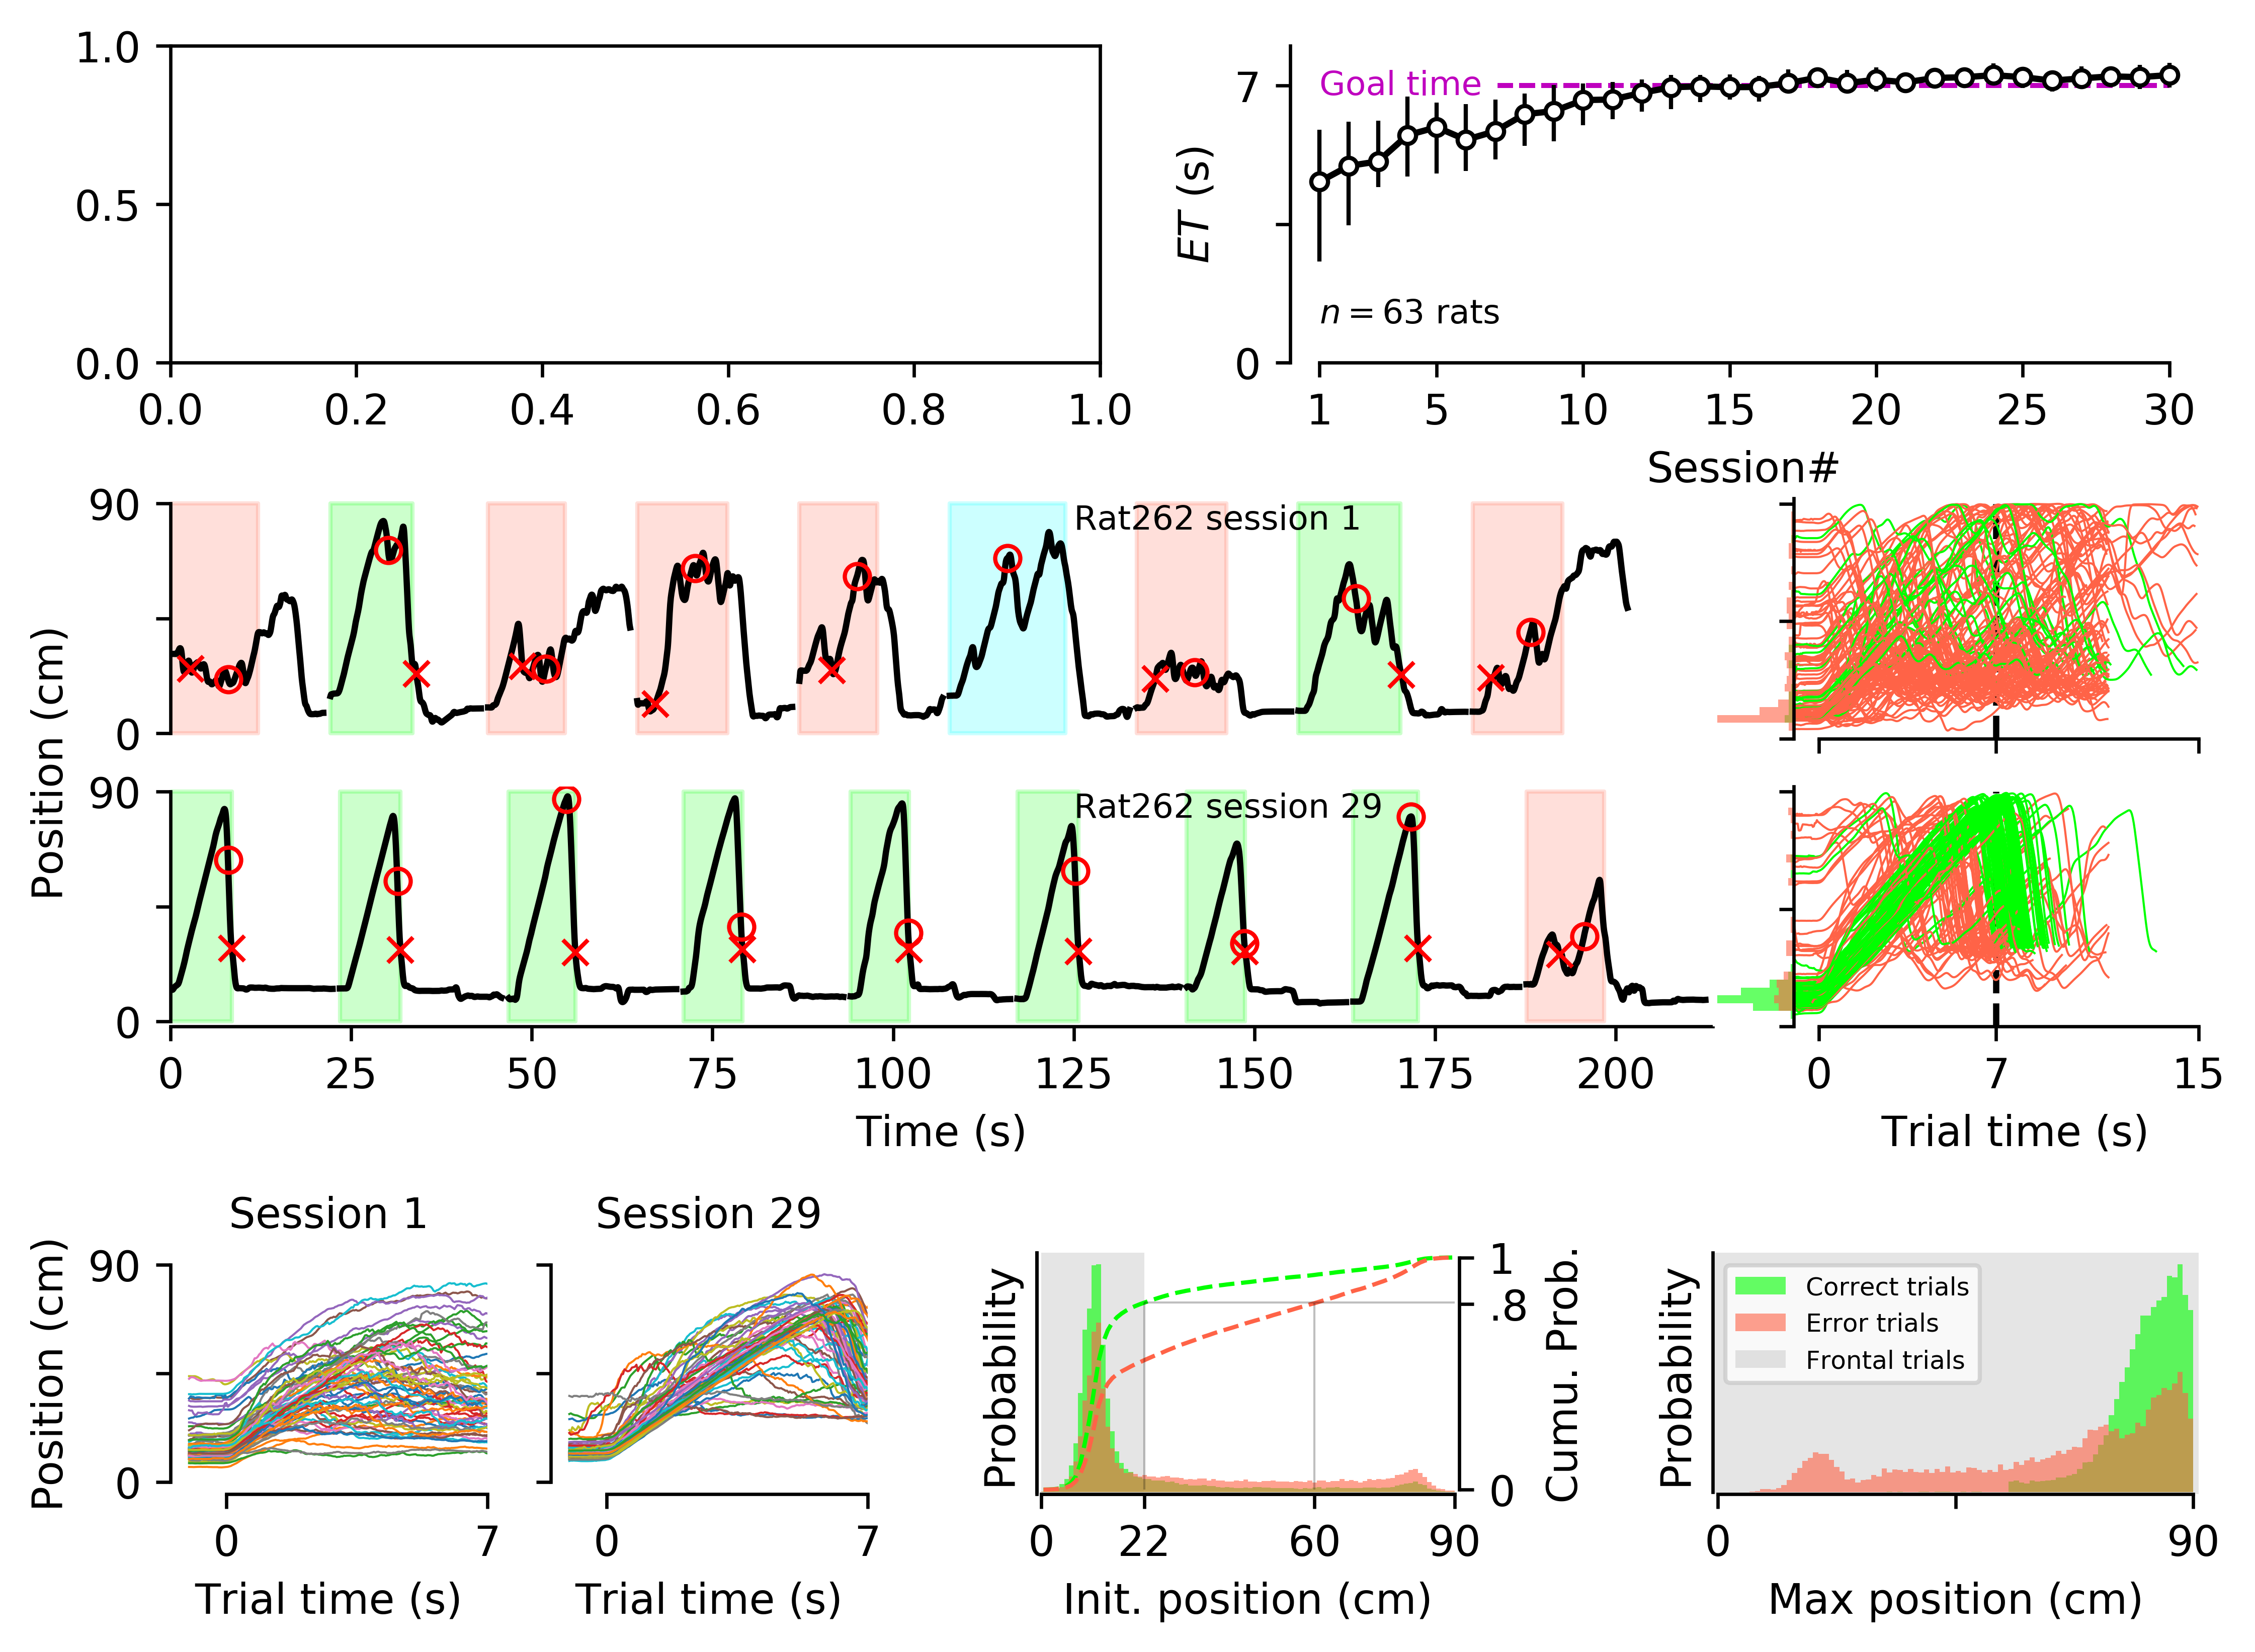

In [4]:
if "__file__" not in dir():
    plt.close('all')
    figsize=(7,5)
    fig=plt.figure(figsize=figsize,dpi=600)
    
    
    ##########################################
    # 1: task rules
    gs1= fig.add_gridspec(nrows=1, ncols=1, left=0.02, bottom=0.77, right=0.46, top=.98)
    ax1= fig.add_subplot(gs1[0])
    
    
    ##########################################
    # 2: learning curve
    gs2= fig.add_gridspec(nrows=1, ncols=1, left=.55, bottom=0.77, right=0.98, top=.98)
    ax2= fig.add_subplot(gs2[0])
    plot_learning_curve(ax2, root, animalList2, profile2, TaskParamToPlot2, stop_dayPlot2)
    ax2.set_ylabel('$ET$ (s)')
    
    
    ###########################################
    # 3: consecutive trajectory examples
    gs3= fig.add_gridspec(nrows=2, ncols=1, left=0.02, bottom=0.33, right=0.75, top=0.68)
    
    naiveAx3= fig.add_subplot(gs3[0])
    plot_consecutive_trajectories(root, session3naive, trials3naive, naiveAx3)
    naiveAx3.text(x=125, y=Y2-10, s=f'{session3trained[:6]} session {day262_0}',fontsize=8)
    
    trainedAx3= fig.add_subplot(gs3[1])
    plot_consecutive_trajectories(root, session3trained, trials3trained, trainedAx3)
    trainedAx3.text(x=125, y=Y2-10, s=f'{session3trained[:6]} session {day262_1}',fontsize=8)
    
    axes3=[naiveAx3, trainedAx3]
    timeMax=max([ax.get_xlim()[1] for ax in axes3])
    for ax in axes3:
        ax.set_xlim([0,timeMax])
        ax.xaxis.set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_bounds(0,90)
        ax.set_ylabel('')
        ax.set_yticks([Y1,Y2/2,Y2])
        ax.set_yticklabels([Y1,'',Y2])
    
    trainedAx3.xaxis.set_visible(True)
    trainedAx3.spines['bottom'].set_visible(True)
    trainedAx3.set_xlabel('Time (s)')
    
#     legend4=add_legend_for_consecutive_trajectories(naiveAx3)
    
    totAx4=fig.add_subplot(gs3[:],frameon=False)
    totAx4.set_ylabel('Position (cm)')
    totAx4.xaxis.set_visible(False)
    totAx4.set_ylim([0,10])
    totAx4.set_yticks([10])
    totAx4.tick_params(color=(0, 0, 0, 0),labelcolor=(0, 0, 0, 0),zorder=-10)

        
    
    ###########################################
    # 4: plot positions trajectories
    gs4= fig.add_gridspec(nrows=2, ncols=1, left=0.75, bottom=0.33, right=0.98, top=0.68)
    
    naiveAx4= fig.add_subplot(gs4[0])
    plot_trajectories_and_distributions(root, naiveAx4, session3naive)
    trainedAx4= fig.add_subplot(gs4[1])
    plot_trajectories_and_distributions(root, trainedAx4, session3trained)
    
    axes4=[naiveAx4, trainedAx4]
    for ax in axes4:
        ax.set_ylabel('')
        ax.set_yticklabels('')
    naiveAx4.set_xlabel('')
    naiveAx4.set_xticklabels([])
    trainedAx4.set_xlabel('         '+'Trial time (s)')

        
    
    ###########################################
    # 5: probabblity of initial pos
    gs5= fig.add_gridspec(nrows=1, ncols=1, left=0.43, bottom=0.02, right=0.63, top=0.18)
    ax5= fig.add_subplot(gs5[0])
    twinAx=plot_probablity_initial_pos(root,profile2,animalList2, SessionRange5, trdBins5, ax5)
#     twinAx.yaxis.label.set_size(8)

    
    ###########################################
    # 6: probabblity of max pos
    gs6= fig.add_gridspec(nrows=1, ncols=1, left=0.75, bottom=0.02, right=0.98, top=0.18)
    ax6= fig.add_subplot(gs6[0])
    plot_prob_max_pos(ax6, animalList2, profile2, SessionRange5, trdBins=trdBins5)


    ###########################################
    # 7: average trajectory plot
    gs7= fig.add_gridspec(nrows=1, ncols=2, left=0.02, bottom=0.02, right=0.35, top=0.18, wspace=wspace7)
    axes7=plot_median_trajectory(root,fig, gs7, profile2, animalList2, SessionRange7)
    axes7[-1].set_yticklabels([])
    axes7[-1].set_ylabel('')
    for ax in axes7: ax.title.set_fontsize(10)

    

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    fig.savefig(os.path.join(os.path.dirname(os.getcwd()),'BehavioralPaper','CtrlTrd.pdf'),
                format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close('all')